In [1]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D



Using TensorFlow backend.


In [2]:
warnings.filterwarnings('ignore')

In [3]:
with open('skin.pkl', 'rb') as fp:
    data = pickle.load(fp)
#print (data.head(5))
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/jupyter/Input/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/jupyter/Input/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/jupyter/Input/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/jupyter/Input/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/jupyter/Input/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


In [4]:
X=data["image"]
Y=data['cell_type_idx']
x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=0.20,random_state=1, shuffle=True, stratify=Y)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.25, random_state = 1, shuffle=True, stratify=y_train)

In [5]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False, # randomly flip images
        rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)  

In [6]:
x_train=np.array(x_train.tolist())
x_validation=np.array(x_validation.tolist())

In [7]:
train_datagen.fit(x_train)
validation_datagen.fit(x_validation)

In [8]:
# build model

In [9]:
IMG_SHAPE = (75, 100, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

W0825 07:08:52.635921 140083212252928 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
base_model.trainable = True
base_model.summary()

print (len(base_model.layers))
for layer in base_model.layers[:17]:
    layer.trainable = False

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 100, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0     

In [11]:
model = tf.keras.Sequential([
  base_model,
    #keras.layers.Flatten(),
    #keras.layers.Dropout(0.9),
    keras.layers.GlobalAveragePooling2D(),
    #keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.7),
  keras.layers.Dense(7, activation='softmax')
])

W0825 07:08:56.460530 140083212252928 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3591      
Total params: 14,718,279
Trainable params: 2,363,399
Non-trainable params: 12,354,880
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00002, beta_1=0.9, beta_2=0.999),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3591      
Total params: 14,718,279
Trainable params: 2,363,399
Non-trainable params: 12,354,880
_________________________________________________________________


In [15]:
history=model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=64),
                    steps_per_epoch=len(x_train) / 64, epochs=10,validation_data=validation_datagen.flow(x_validation, y_validation,batch_size=64),validation_steps=len(x_validation)/64)

Epoch 1/10
94/93 [==============================] - 20s 209ms/step - loss: 1.9079 - acc: 0.4470 - val_loss: 1.2788 - val_acc: 0.6695
Epoch 2/10
94/93 [==============================] - 16s 166ms/step - loss: 1.4221 - acc: 0.5898 - val_loss: 1.0851 - val_acc: 0.6735
Epoch 3/10
94/93 [==============================] - 15s 165ms/step - loss: 1.2890 - acc: 0.6053 - val_loss: 1.0068 - val_acc: 0.6775
Epoch 4/10
94/93 [==============================] - 15s 165ms/step - loss: 1.2136 - acc: 0.6142 - val_loss: 0.9579 - val_acc: 0.6805
Epoch 5/10
94/93 [==============================] - 15s 164ms/step - loss: 1.1439 - acc: 0.6297 - val_loss: 0.9307 - val_acc: 0.6860
Epoch 6/10
94/93 [==============================] - 15s 164ms/step - loss: 1.0701 - acc: 0.6529 - val_loss: 0.9104 - val_acc: 0.6950
Epoch 7/10
94/93 [==============================] - 15s 163ms/step - loss: 1.0375 - acc: 0.6622 - val_loss: 0.8825 - val_acc: 0.7014
Epoch 8/10
94/93 [==============================] - 16s 165ms/step - 

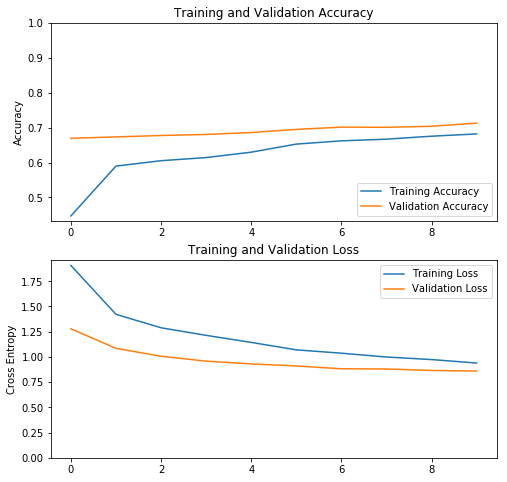

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()